In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [62]:
features = ['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']

Read dataset

In [63]:
df = pd.read_csv("../03-classification/data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [64]:
def data_prep(df, features):
    
    # filtering on feaures of interest
    df_f = df[features]

    # columns names to lower and 
    df_f.columns = df_f.columns.str.replace(" ","_").str.lower()
    
    # Missing values with 0
    df_f = df_f.fillna(0)

    # Getting average for msrp
    average = data['msrp'].mean()
    df_f['above_average'] = (df_f.msrp > average).astype('int')

    return df_f

In [65]:
data = data_prep(df, features)

In [66]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

print(len(df_train))
print(len(df_val))
print(len(df_test))

7148
2383
2383


Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

engine_hp
engine_cylinders
highway_mpg
city_mpg

In [67]:
from sklearn.metrics import auc, roc_auc_score

In [68]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
dtype: object

In [157]:
roc_auc_score(y_train, df_train['engine_hp'])

0.9164757999917978

In [161]:
roc_auc_score(y_train, -df_train['city_mpg'])

0.6723270402704458

In [162]:
roc_auc_score(y_train, -df_train['highway_mpg'])

0.6316523655095094

In [160]:
roc_auc_score(y_train, df_train['engine_cylinders'])

0.7671850522495359

Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.678
0.779
0.878
0.979

In [126]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [127]:
from sklearn.metrics import roc_curve

In [128]:
def model_training(df_t, df_v, y_train, y_val):
    train_dict = df_t.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)  

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dict = df_v.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val)[:, 1]

    # fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    return y_pred

In [129]:
y_pred = model_training(df_train, df_val, y_train, y_val)

auc_score = print(np.round(roc_auc_score(y_val, y_pred),3))

0.98


Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.28
0.48
0.68
0.88

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [90]:
scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    precision =  precision_score(y_val, y_pred >=t)
    recall = recall_score(y_val, y_pred >= t)
    scores.append((t, precision, recall))
    

/Users/avinashshruthi/miniforge3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
columns = ['threshold', 'precision','recall']
df_scores = pd.DataFrame(scores, columns=columns)


In [93]:
df_scores

,threshold,precision,recall
0,0.00,0.274444,1.000000
1,0.01,0.455625,0.996942
2,0.02,0.505828,0.995413
3,0.03,0.539354,0.995413
4,0.04,0.569676,0.993884
...,...,...,...
96,0.96,0.996310,0.412844
97,0.97,0.996078,0.388379
98,0.98,1.000000,0.357798
99,0.99,1.000000,0.295107


In [102]:
values = [0.28,0.48,0.68,0.88]

In [103]:
df_scores[df_scores['threshold'].isin(values)]

,threshold,precision,recall
28,0.28,0.808511,0.929664
48,0.48,0.887367,0.891437
68,0.68,0.944238,0.776758
88,0.88,0.992208,0.584098


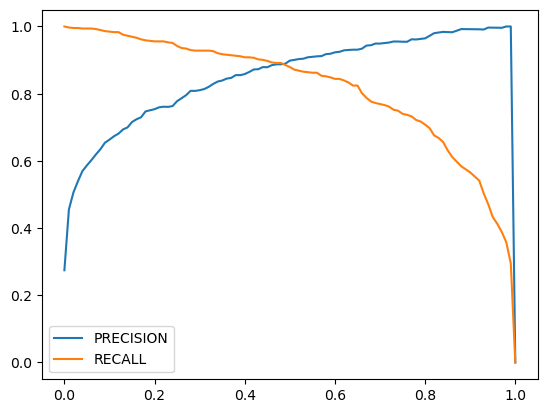

In [95]:
plt.plot(df_scores.threshold, df_scores['precision'], label='PRECISION')
plt.plot(df_scores.threshold, df_scores['recall'], label='RECALL')
plt.legend()

Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 

Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.12
0.32
0.52
0.72

In [130]:
f1_scores = []

thresholds = np.linspace(0,1,101)

for t in thresholds:
    f1 =  f1_score(y_val, y_pred > t)
    f1_scores.append((t, f1))

In [131]:
columns = ['threshold', 'f1']
df_f1_scores = pd.DataFrame(f1_scores, columns=columns)

In [132]:
df_f1_scores[df_f1_scores['f1'] == df_f1_scores.f1.max()]

,threshold,f1
44,0.44,0.889728


In [163]:
f1_values = [0.12, 0.32, 0.52, 0.72]
df_f1_scores[df_f1_scores['threshold'].isin(f1_values)]


,threshold,f1
12,0.12,0.804756
32,0.32,0.870875
52,0.52,0.885425
72,0.72,0.846219


Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the scores across different folds?

0.003
0.030
0.090
0.140


In [133]:
!pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [134]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [135]:
df_train_full.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
2711,Mercedes-Benz,CLK-Class,2007,382.0,8.0,AUTOMATIC,Coupe,22,15,54900,1
333,Nissan,370Z,2016,332.0,6.0,MANUAL,Coupe,26,18,29990,0
9377,GMC,Sierra 1500,2017,285.0,6.0,AUTOMATIC,Extended Cab Pickup,24,18,32230,0
939,Porsche,911,2016,350.0,6.0,MANUAL,Convertible,26,19,102930,1
5675,Volkswagen,GTI,2013,200.0,4.0,MANUAL,4dr Hatchback,31,21,28795,0


In [147]:
del df_train_full['msrp']

In [136]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [137]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [149]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    

print(scores)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))   

[0.9784877485355994, 0.9808379513568193, 0.9829931403714238, 0.9797487591322291, 0.9776709401709401]
0.980 +- 0.002


Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.01
0.1
0.5
10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [156]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train['above_average']
        del df_val['above_average']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.001
C=0.5 0.979 +- 0.003
C=10 0.983 +- 0.003
